# Internal Datastructure: Bus branch model, Admittance and Jacobian Matrix


This jupyter notebooks explains how to access and interpret the internal datastructure with relevant matrices.

### Internal Datastructure

We use the simple example network from the create_simple tutorial as an example for how to access internal calculation parameters:

<img src="pics/example_network_simple.png">


In [1]:
import pandapower as pp
import pandapower.networks as nw

net = nw.example_simple()
print(net)

LightSimBackend import error: No module named 'grid2op'
PhysicalLawChecker import error: No module named 'grid2op'
TimeSerie import error: cannot import name 'TimeSerie' from 'lightsim2grid.timeSerie' (C:\ProgramData\miniconda3\envs\py3.11\Lib\site-packages\lightsim2grid\timeSerie.py)
ContingencyAnalysis import error: cannot import name 'ContingencyAnalysis' from 'lightsim2grid.contingencyAnalysis' (C:\ProgramData\miniconda3\envs\py3.11\Lib\site-packages\lightsim2grid\contingencyAnalysis.py)
rewards import error: No module named 'grid2op'
This pandapower network includes the following parameter tables:
   - bus (7 elements)
   - load (1 element)
   - sgen (1 element)
   - gen (1 element)
   - switch (8 elements)
   - shunt (1 element)
   - ext_grid (1 element)
   - line (4 elements)
   - trafo (1 element)


First, we run a power flow in this network:

In [2]:
pp.runpp(net)

When a power flow is carried out, the element based grid model is translated into a bus-branch model. That bus-branch model is stored in a data structure that is based on the PYPOWER/MATPOWER casefile (with some extensions). This ppc can be accesed after power flow:

In [3]:
net._ppc

{'baseMVA': 1,
 'version': 2,
 'bus': array([[  0.        ,   3.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   1.        ,   1.02      ,
          50.        , 110.        ,   1.        ,   2.        ,
           0.        ,   0.        ,   0.        ,   0.        ],
        [  1.        ,   1.        ,   0.        ,   0.        ,
           0.        ,   0.96      ,   1.        ,   1.02082951,
          50.03241357, 110.        ,   1.        ,   2.        ,
           0.        ,   0.        ,   0.        ,   0.        ],
        [  2.        ,   1.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   1.        ,   1.02456241,
         -98.19715207,  20.        ,   1.        ,   2.        ,
           0.        ,   0.        ,   0.        ,   0.        ],
        [  3.        ,   2.        ,   0.        ,   0.        ,
           0.        ,   0.        ,   1.        ,   1.03      ,
         -98.12954543,  20.        ,   1.        ,

For information on how this datastructure is defined, please refer to the MATPOWER documentation.

**Note:** For linear power flow (DC load flow) 'Ybus' is no longer created, but 'Bbus' as a new 'internal' key.

In [4]:
pp.rundcpp(net)
net._ppc['internal']['Bbus'].A

array([[ 8402.77777778+0.j, -8402.77777778+0.j,     0.        +0.j,
            0.        +0.j,     0.        +0.j,     0.        +0.j],
       [-8402.77777778+0.j,  8611.22995659+0.j,  -208.45217882+0.j,
            0.        +0.j,     0.        +0.j,     0.        +0.j],
       [    0.        +0.j,  -208.45217882+0.j,  3422.7378931 +0.j,
        -1785.71428571+0.j, -1428.57142857+0.j,     0.        +0.j],
       [    0.        +0.j,     0.        +0.j, -1785.71428571+0.j,
         2092.93394777+0.j,     0.        +0.j,  -307.21966206+0.j],
       [    0.        +0.j,     0.        +0.j, -1428.57142857+0.j,
            0.        +0.j,  1428.57142857+0.j,     0.        +0.j],
       [    0.        +0.j,     0.        +0.j,     0.        +0.j,
         -307.21966206+0.j,     0.        +0.j,   307.21966206+0.j]])

## Nodal Point Admittance Matrix

The nodal point admittance matrix is saved in the ppc and can be accessed directly:

In [5]:
pp.runpp(net)
net._ppc["internal"]["Ybus"].todense()

matrix([[ 2983.234714  -7157.02635809j, -2983.234714  +7159.76331361j,
             0.           +0.j        ,     0.           +0.j        ,
             0.           +0.j        ,     0.           +0.j        ],
        [-2983.234714  +7159.76331361j,  2990.35626947-7364.28068082j,
           -97.94315042 -183.87162407j,     0.           +0.j        ,
             0.           +0.j        ,     0.           +0.j        ],
        [    0.           +0.j        ,   110.26592227 -176.75706842j,
          1608.40491554-1678.15899439j,  -889.60186671 +816.68368091j,
          -711.68149336 +653.34694473j,     0.           +0.j        ],
        [    0.           +0.j        ,     0.           +0.j        ,
          -889.60186671 +816.68368091j,  1027.81021222 -903.21268537j,
             0.           +0.j        ,  -138.20834551  +86.56929539j],
        [    0.           +0.j        ,     0.           +0.j        ,
          -711.68149336 +653.34694473j,     0.           +0.j        ,
  

Note that the nodal point admittance matrix is given in per unit values.

## Jacobian Matrix

The jacobian Matrix J in the last iteration step is also stored in the ppc and can be accessed:

In [6]:
net._ppc["internal"]["J"].todense()

matrix([[ 9.54796429e+02,  0.00000000e+00, -8.62952847e+02,
          0.00000000e+00, -9.18435819e+01,  0.00000000e+00,
         -9.15296722e+02,  0.00000000e+00, -1.42353628e+02],
        [ 0.00000000e+00,  7.67426446e+03, -2.17432759e+02,
          0.00000000e+00,  0.00000000e+00,  3.05264391e+03,
         -1.38258877e+01,  0.00000000e+00,  0.00000000e+00],
        [-8.60737366e+02, -2.17892547e+02,  1.76161072e+03,
         -6.82980810e+02,  0.00000000e+00, -6.95207957e-01,
          1.64791122e+03, -7.30904816e+02,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -6.86871045e+02,
          6.86871045e+02,  0.00000000e+00,  0.00000000e+00,
         -7.26450957e+02,  7.28978161e+02,  0.00000000e+00],
        [-9.18403982e+01,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  9.18403982e+01,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  1.42355564e+02],
        [ 0.00000000e+00, -3.11622898e+03,  1.41654849e+01,
          0.00000000e+00,  0.000000

The jacobian matrix is also given in per unit values.

## Mapping the Buses

The pandapower indices are not equal to the ppc indices for several reasons. Some buses are fused together in case of closed bus-bus switches and auxiliary buses are created for elements like extended wards or three winding transformers.
See here for more details: https://pandapower.readthedocs.io/en/latest/elements/switch.html

There is however a mapping between pandapower indices and ppc indices that is created during the conversion to keep track of the dependencies that is also stored in the net:

In [7]:
net._pd2ppc_lookups["bus"]

array([0, 1, 1, 2, 2, 3, 4], dtype=int64)

To get a ppc index from the pandapower index, simply call the lookup like this:

In [8]:
pandapower_bus_idx = 3
ppc_index = net._pd2ppc_lookups["bus"][pandapower_bus_idx]
print(ppc_index)

2


As you can see, pandapower bus index 3 corresponds to ppc bus index 2. So if we would like to find the diagonal entry of the Ybus matrix for bus 2, we could now access it with that internal index:

In [9]:
Ybus = net._ppc["internal"]["Ybus"]
int_idx = net._pd2ppc_lookups["bus"][ppc_index]
Ybus[int_idx, int_idx]

(2990.356269470474-7364.280680821408j)

We can also see that some buses are mapped to the same internal bus, such as bus 1 and bus 2:

In [10]:
print(net._pd2ppc_lookups["bus"][1])
print(net._pd2ppc_lookups["bus"][2])

1
1


That is because buses 1 and 2 are connected by a closed bus-bus switch and are therefore represented internally as the same bus:

In [11]:
net.switch.loc[0]

bus           1
element       2
et            b
type         CB
closed     True
name       None
z_ohm       0.0
in_ka       NaN
Name: 0, dtype: object

## Obtaining Jacobian Entries of Generators

As an example we show how to obtain the Jacobian entries of generator buses using the pandapower -> ppc bus mapping. First we get buses of the in-service generators:

In [12]:
gen_buses = net.gen.loc[net.gen.in_service.values, "bus"].values
print(f"pandapower gen bus: {gen_buses}")

pandapower gen bus: [5]


Second, we geht the Jacobian matrix:

In [13]:
J = net._ppc["internal"]["J"]
print(f"Jacobian shape: {J.shape}")

Jacobian shape: (9, 9)


Why has the Jacobian the shape 9x9?
It consists of the partial derivatives J11 = dP_dVa, J12 = dP_Vm, J21 = dQ_dVa, J22 = dQ_dVm. Except the reference bus, all PV- and PQ-buses are included in J. Vm is constant for PV nodes and dS/dVm is 0 for PV-buses (gens in pandapower) and Q is a variable. 

In our case we have 1 reference bus (at bus 0), 1 gen at bus 5, and 3 pq buses (at buses 1, 2, 4)

This is the reason why J11 to J22  have these shapes:

J11 = pvpq x pvpq (dP_dVa)

J12 = pvpq x pq (dP_dVm)

J21 = pq x pvpq (dQ_dVa)

J22 = pq x pq (dQ_dVm)

Only J11 contains values relevant for gens.

In [14]:
bus_lookup = ppc_index = net._pd2ppc_lookups["bus"]
print(f"pandapower to ppc lookup: {bus_lookup}")
ppc_gen_buses = bus_lookup[gen_buses]
print(f"pandapower gen bus: {gen_buses} maps to ppc gen bus: {ppc_gen_buses}")

pandapower to ppc lookup: [0 1 1 2 2 3 4]
pandapower gen bus: [5] maps to ppc gen bus: [3]


Now, we need the pv and pq entries in J to obtain the Jacobian sub-matrices:

In [15]:
import numpy as np

# get pv and pq values from newtonpf()
pv = net._ppc["internal"]["pv"]
pq = net._ppc["internal"]["pq"]
# stack these as done in newtonpf()
pvpq = np.hstack((pv, pq))

print("pv and pq nodes as in the newtonpf() function")
print(f"pv buses: {pv}\npq buses: {pq}\npvpq buses: {pvpq}")

# get len of pv and pq
n_pvpq = len(pvpq)
n_pq = len(pq)
n_pv = len(pv)
# get J11, J12, J21, and J22
j11 = J[:n_pvpq, :n_pvpq]
j12 = J[:n_pvpq, n_pvpq:]
j21 = J[n_pvpq:, :n_pvpq]
j22 = J[n_pvpq:, n_pvpq:]

print("shape of J sub-matrices:")
print(f"j11 = {j11.shape}")
print(f"j12 = {j12.shape}")
print(f"j21 = {j21.shape}")
print(f"j22 = {j22.shape}")


pv and pq nodes as in the newtonpf() function
pv buses: [3]
pq buses: [1 2 4 5]
pvpq buses: [3 1 2 4 5]
shape of J sub-matrices:
j11 = (5, 5)
j12 = (5, 4)
j21 = (4, 5)
j22 = (4, 4)


Now, we finally get the generator entries in J:

In [16]:
# j11 gen entries
m = np.isin(pvpq, pv)
n = m

j11_gen_entries = j11[m, n]
print(f"J11 indices: m = {m}, n = {n}")
print(f"pandapower gen {gen_buses} entries (ppc PV nodes {ppc_gen_buses}) in J11 (=dP/dVa): {j11_gen_entries}")

J11 indices: m = [ True False False False False], n = [ True False False False False]
pandapower gen [5] entries (ppc PV nodes [3]) in J11 (=dP/dVa): [[954.79642892]]


# Visiualizing the Matrices
You can easily visualize the matrices with matplotlib and the plot function spy(). Let's look at an example.

First, we define a plot function to visiualize the sparse Ybus matrix (works also with any other matrix like J) including some labels:

In [17]:
import matplotlib.pyplot as mpl
import numpy as np

import pandapower as pp
import pandapower.networks as nw
import pandapower.plotting as plt
from pandapower.plotting import get_collection_sizes

def plot_ybus(net=None, ax=None, ybus=None):
    if ax is None:
        fig, ax = mpl.subplots(1, 2)
    if ybus is None:
        ybus = net._ppc["internal"]["Ybus"]
    ax.spy(ybus)
    ax.set_title("Ybus shape {}\n".format(str(ybus.shape)))
    ax.set_xticks(np.arange(ybus.shape[0]))
    ax.set_xticklabels(np.arange(ybus.shape[0]))
    ax.set_yticklabels(np.arange(ybus.shape[1]))
    ax.set_yticks(np.arange(ybus.shape[1]))

    ax.grid(which="both", linestyle="dotted")

Second, we define a function to plot the power system including some bus labels and other collections:

In [18]:
def plot_net(net, ax=None):
    import geojson
    if ax is None:
        fig, ax = mpl.subplots(1, 1, figsize=(10, 8))

    sizes = get_collection_sizes(net)

    # create collections for elements
    collections = list()
    collections.append(plt.create_bus_collection(net, size=sizes["bus"]))
    collections.append(plt.create_line_collection(net, use_bus_geodata=True))
    collections.append(plt.create_trafo_collection(net, size=sizes["trafo"]))
    collections.append(plt.create_ext_grid_collection(net, size=sizes["ext_grid"], orientation=1.5))
    collections.append(plt.create_bus_bus_switch_collection(net, size=sizes["switch"]))
    collections.append(
        plt.create_line_switch_collection(net, distance_to_bus=sizes["switch_distance"], size=sizes["switch"]))
    collections.append(plt.create_load_collection(net, size=sizes["load"]))

    # add labels for each bus
    for idx in net.bus.geo.index:
        x, y = geojson.loads(net.bus.loc[idx, 'geo']).coordinates 
        y += sizes["bus"] * 1.
        ax.text(x, y, str(idx), fontsize=12, color="r")

    plt.draw_collections(collections, ax=ax)
    mpl.tight_layout()

Third, we create a plot function with three subplots. The first subplots shows the power system including the bus labels. The second and third plot shows the Ybus matrix with different settings. If you just call runpp() the buses are fused internally and the Ybus matrix has a lower dimension. You can also use the parameter `r_switch` to set impedance values for switches. In this case, the buses are not fused and the Ybus matrix has a higher dimension. This also changes your power flow result.

In [19]:
def plot_overview(net):
    fig, axes = mpl.subplots(1, 3, figsize=(16, 8))
    pp.runpp(net)
    plot_net(net, ax=axes[0])
    # plot y bus with max. const shape (no fused switches)
    pp.runpp(net, check_connectivity=False, r_switch=0.1, init="flat", neglect_open_switch_branches=True)
    plot_ybus(net, ax=axes[1])
    # plot ybus for power flow (with fused switches)
    pp.runpp(net)
    plot_ybus(net, ax=axes[2])
    mpl.show()

Finally, we call the overview function with the cigre example power system:

C:\Users\mvogt\AppData\Local\Temp\ipykernel_17836\3533381797.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(ybus.shape[1]))
C:\Users\mvogt\AppData\Local\Temp\ipykernel_17836\3533381797.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(ybus.shape[1]))


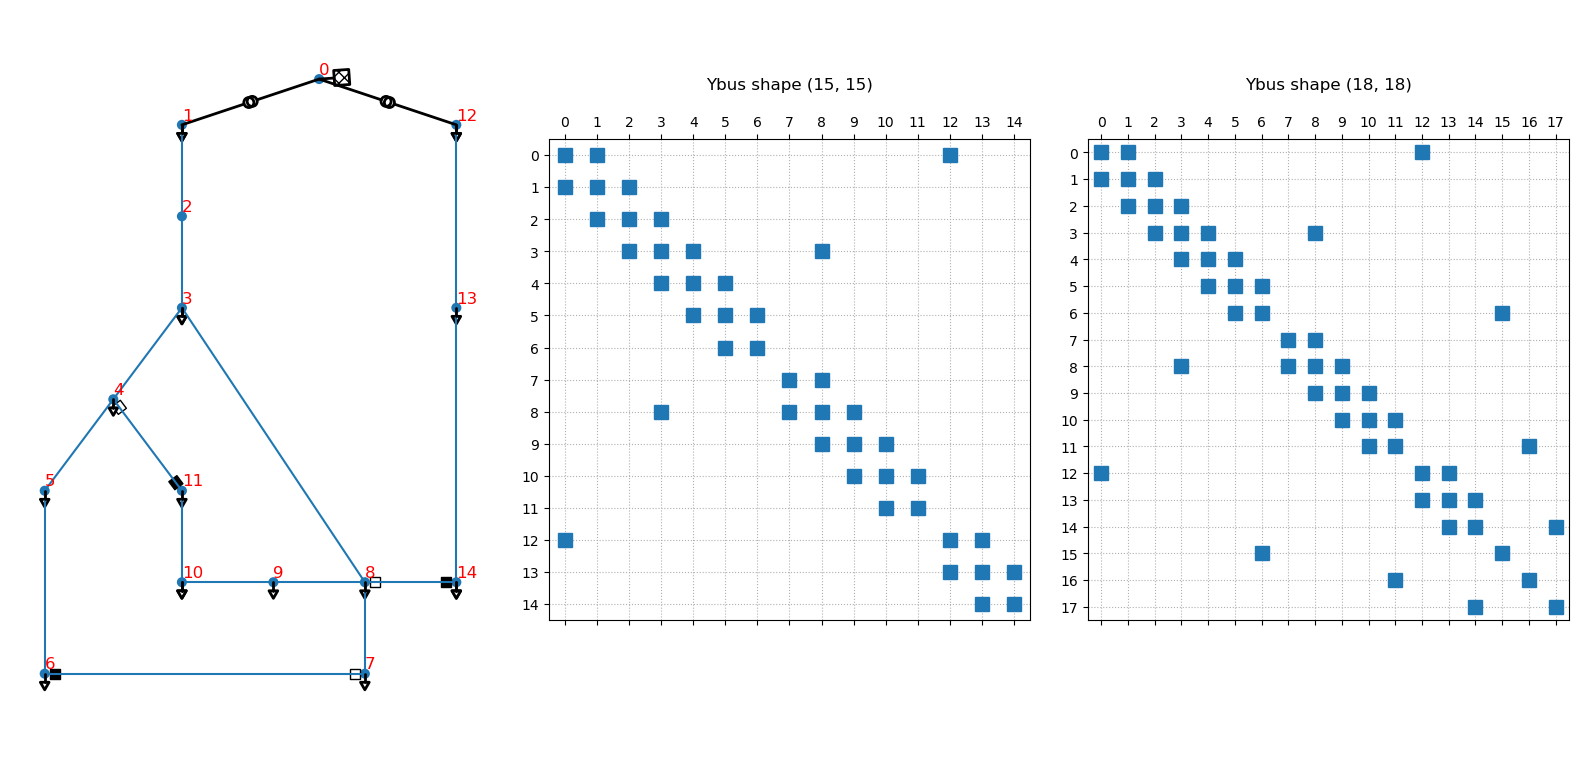

In [20]:
net = nw.create_cigre_network_mv()
plot_overview(net)

Each dot in the spy plot is ea